# STEP 1. Import Packages (MUST BE DONE FIRST)

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline
import datetime
import talib
import torch
import itertools
import stable_baselines3

import warnings
warnings.filterwarnings('ignore')

from finrl.apps import config
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline, convert_daily_return_to_pyfolio_ts
from finrl.finrl_meta.data_processor import DataProcessor
from finrl.finrl_meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
from pprint import pprint
import sys
sys.path.append("../FinRL-Library")

import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

# STEP 2. Load Data

In [ ]:
# Tics: 'B' => 'Bitcoin', 'G' => 'Gold'
# Available: '1' => 'Yes', '0' => 'No'
data = pd.DataFrame(pd.read_csv(r"C:\Users\SEAN\Desktop\2022_MCM_ICM_Problems\data.csv", header=0))
data['date'] = pd.to_datetime(data['date'])

In [ ]:
data.head()

In [ ]:
data.shape

# STEP 3. Use TA-Lib to Calculate Tech Indicators

In [ ]:
# Indicators: 'macd', 'rsi_30', 'close_30_sma'
data['close'] /= 1000.0 # Price was scaled
bitcoinprice = data[data['tic']=='B']
goldprice = data[data['tic']=='G']
bitcoinprice['rsi_30'] = talib.RSI(bitcoinprice.close, timeperiod=30)
goldprice['rsi_30'] = talib.RSI(goldprice.close, timeperiod=30)
bitcoinprice['macd'], signal, hist = talib.MACD(bitcoinprice.close, fastperiod=12, slowperiod=26, signalperiod=9)
goldprice['macd'], signal, hist = talib.MACD(goldprice.close, fastperiod=12, slowperiod=26, signalperiod=9)
bitcoinprice['close_30_sma']= talib.SMA(bitcoinprice.close, timeperiod=30)
goldprice['close_30_sma']= talib.SMA(goldprice.close, timeperiod=30)
df = pd.concat([bitcoinprice,goldprice],axis=0)
df = df.sort_index()
df.to_csv(r"C:\Users\SEAN\Desktop\2022_MCM_ICM_Problems\data_with_indicators_new.csv")

# STEP 4. Preprocess Data (MUST DONE SECOND)

#### NOTE: THE PRICES ARE SCALED (1000:1). INDICATORS ARE CALCULATED FROM SCALED PRICES.

In [2]:
df = pd.DataFrame(pd.read_csv(r"C:\Users\SEAN\Desktop\2022_MCM_ICM_Problems\data_with_indicators_new.csv", header=0))
df['date'] = pd.to_datetime(df['date'])

fe = FeatureEngineer(
                    use_technical_indicator=False,
                    use_vix=False,
                    use_turbulence=False,
                    user_defined_feature=False)

processed = fe.preprocess_data(df) # Only clean data
processed.head()

,date,tic,close,macd,rsi_30,close_30_sma,available
0,2016-09-11,B,0.62165,0.005956,46.651742,0.608718,1
0,2016-09-11,G,1.32460,0.005956,46.651742,0.608718,0
1,2016-09-12,B,0.60967,0.005956,46.651742,0.608718,1
1,2016-09-12,G,1.32460,0.005956,46.651742,0.608718,1
2,2016-09-13,B,0.61092,0.005956,46.651742,0.608718,1


# STEP 5. Design Environment

In [ ]:
train = data_split(processed, '2016-10-15','2017-01-11')
trade = data_split(processed, '2017-01-11','2017-02-11')
print(len(train))
print(len(trade))

In [ ]:
train.tail()

In [ ]:
trade.head()

In [ ]:
config.TECHNICAL_INDICATORS_LIST

In [ ]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

In [ ]:
env_kwargs = {
    "stock_dim": stock_dimension, 
    "hmax": 100, 
    "initial_amount": 1000, 
    "buy_cost_pct": [0.02, 0.01], # Placed in order
    "sell_cost_pct": [0.02, 0.01], # Placed in order
    "reward_scaling": 1e-4,
    "state_space": state_space, 
    "action_space": stock_dimension,
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST,
    "print_verbosity": 50,
    "model_name": 'try',
    "mode": 'try'
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [ ]:
# Environment for training
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

# STEP 6. Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

## Model Training

#### NOTE: State = [ balance, cls_b, cls_g, share_b, share_g, macd_b, macd_g, rsi_b, rsi_g, sma_b, sma_g, ava_b, ava_g ] 

### Model 1. A2C

In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c",
                           verbose=0)

In [ ]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

### Model 2. DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg",
                            verbose=0)

In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

### Model 3. PPO

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

In [ ]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=100000)

### Model 4. TD3

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

In [ ]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000)

### Model 5. SAC

In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

In [ ]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=60000)

## Model Trading
DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [ ]:
#trade = data_split(processed_full, '2020-07-01','2021-10-31')
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym)

In [ ]:
df_account_value.shape

In [ ]:
df_account_value.tail()

In [ ]:
df_actions.head()

In [ ]:
e_trade_gym.render()

# STEP 7. PPO with Variant-Data-Window-Sliding Iteration (BEGIN HERE)

## Environment Settings 

In [65]:
# Windows of variant length
# The last day of each period is ONLY used for calculating reward, so one more day should be included on trade mode
train = data_split(processed, '2016-10-14','2021-09-10')
trade = data_split(processed, '2016-09-11','2021-09-10')
print((len(train)/2)-1)
print((len(trade)/2)-1)

stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

# PLEASE update initial_state
initial_state = [3.381954326938228, 6.296320833, 1.18985, 85.0, 6.0, -0.109973814, -0.002091948, 43.18739003, 39.99853958, 6.633974169, 1.194901667, 1, 1]
initial_asset = initial_state[0] + sum(np.array(initial_state[1 : (stock_dimension + 1)])
                * np.array(initial_state[(stock_dimension + 1) : (stock_dimension * 2 + 1)]))
hmax = initial_asset // (np.max(np.array(initial_state[1 : (stock_dimension + 1)]))*10)
print(initial_asset, hmax)
env_kwargs = {
    "initial": True, # CHANGE
    "previous_state": [], # CHANGE
    "stock_dim": stock_dimension, 
    "hmax": 100, #CHANGE
    # =100 if uninitialized
    "initial_amount": 1000, # CHANGE
    # =1000 if uninitialized
    "buy_cost_pct": [0.02, 0.005], # CHANGE, [B, G]
    "sell_cost_pct": [0.02, 0.005], # CHANGE, [B, G]
    "reward_scaling": 1e-1,
    "state_space": state_space, 
    "action_space": stock_dimension,
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST,
    "print_verbosity": 10,
    "model_name": 'b2', # CHANGE
    "mode": 'g0.5' # CHANGE
}

1792.0
1825.0
Stock Dimension: 2, State Space: 13
545.7083251319382 8.0


## Training

In [66]:
e_train_gym = StockTradingEnv(df = train, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 4196,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 4196, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [67]:
MODEL = stable_baselines3.ppo.PPO.load(r'C:\Users\SEAN\Desktop\PPO',
                                       env=env_train,
                                       device="cuda")
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=500000) # CHANGE
trained_ppo.save(r"C:\Users\SEAN\Desktop\PPO")

[1.710367423301322, 46.36869, 1.7946, 0.0, 1.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
[1.4107629506999435, 46.36869, 1.7946, 0.0, 1.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
-----------------------------
| time/              |      |
|    fps             | 315  |
|    iterations      | 1    |
|    time_elapsed    | 13   |
|    total_timesteps | 4196 |
| train/             |      |
|    reward          | 0.0  |
-----------------------------
[1.0786055680392124, 46.36869, 1.7946, 0.0, 1.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
[1.0730376676197964, 46.36869, 1.7946, 0.0, 1.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
------------------------------------------
| time/                   |              |
|    fps                  | 288          |
|    iterations           | 2            |
|    time_elapsed         | 29           |
|    tot

[10.999847777878601, 46.36869, 1.7946, 0.0, 0.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
day: 1792, episode: 20
begin_total_asset: 1000.00
end_total_asset: 11.00
total_reward: -989.00
total_cost: 3861.54
total_trades: 2495
Sharpe: -1.418
[1.5469653111200519, 46.36869, 1.7946, 0.0, 0.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
[0.1257544283175278, 46.36869, 1.7946, 0.0, 19.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
------------------------------------------
| time/                   |              |
|    fps                  | 269          |
|    iterations           | 9            |
|    time_elapsed         | 140          |
|    total_timesteps      | 37764        |
| train/                  |              |
|    approx_kl            | 8.431086e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84      

[1.5991198534400506, 46.36869, 1.7946, 0.0, 0.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
[12.73588877613803, 46.36869, 1.7946, 9.0, 246.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
-------------------------------------------
| time/                   |               |
|    fps                  | 266           |
|    iterations           | 16            |
|    time_elapsed         | 252           |
|    total_timesteps      | 67136         |
| train/                  |               |
|    approx_kl            | 0.00055094715 |
|    clip_fraction        | 0.00101       |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.86         |
|    explained_variance   | 0.73          |
|    learning_rate        | 0.00025       |
|    loss                 | 16            |
|    n_updates            | 150           |
|    policy_gradient_loss | -0.00238      |
|    reward               | 0.1611175    

[1.6831372825800703, 46.36869, 1.7946, 0.0, 0.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
[0.09681029735283175, 46.36869, 1.7946, 92.0, 428.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
-------------------------------------------
| time/                   |               |
|    fps                  | 265           |
|    iterations           | 23            |
|    time_elapsed         | 363           |
|    total_timesteps      | 96508         |
| train/                  |               |
|    approx_kl            | 0.00014224379 |
|    clip_fraction        | 4.73e-05      |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.85         |
|    explained_variance   | 0.142         |
|    learning_rate        | 0.00025       |
|    loss                 | 412           |
|    n_updates            | 220           |
|    policy_gradient_loss | -0.000831     |
|    reward               | 4.925216  

[353.438169755021, 46.36869, 1.7946, 0.0, 773.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
[1.1363505814169201, 46.36869, 1.7946, 3.0, 18.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
day: 1792, episode: 70
begin_total_asset: 1000.00
end_total_asset: 172.55
total_reward: -827.45
total_cost: 3830.93
total_trades: 2517
Sharpe: -0.503
[1.345975345958479, 46.36869, 1.7946, 0.0, 27.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
------------------------------------------
| time/                   |              |
|    fps                  | 265          |
|    iterations           | 30           |
|    time_elapsed         | 474          |
|    total_timesteps      | 125880       |
| train/                  |              |
|    approx_kl            | 9.170096e-05 |
|    clip_fraction        | 0.000237     |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.86     

[43.30598818870203, 46.36869, 1.7946, 12.0, 0.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
[0.9929302281556147, 46.36869, 1.7946, 0.0, 2439.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
-------------------------------------------
| time/                   |               |
|    fps                  | 263           |
|    iterations           | 37            |
|    time_elapsed         | 588           |
|    total_timesteps      | 155252        |
| train/                  |               |
|    approx_kl            | 0.00020254501 |
|    clip_fraction        | 0.000284      |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.86         |
|    explained_variance   | 0.302         |
|    learning_rate        | 0.00025       |
|    loss                 | 677           |
|    n_updates            | 360           |
|    policy_gradient_loss | -0.000627     |
|    reward               | 46.263298  

[1.0913224698346369, 46.36869, 1.7946, 0.0, 2473.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
[58637.08483953056, 46.36869, 1.7946, 109.0, 0.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
-------------------------------------------
| time/                   |               |
|    fps                  | 263           |
|    iterations           | 44            |
|    time_elapsed         | 700           |
|    total_timesteps      | 184624        |
| train/                  |               |
|    approx_kl            | 4.1537693e-05 |
|    clip_fraction        | 0.000142      |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.86         |
|    explained_variance   | 0.295         |
|    learning_rate        | 0.00025       |
|    loss                 | 1.86e+03      |
|    n_updates            | 430           |
|    policy_gradient_loss | -0.000369     |
|    reward               | 0.0       

[1.658456470860059, 46.36869, 1.7946, 0.0, 0.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
[3106.316505570723, 46.36869, 1.7946, 18.0, 0.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
day: 1792, episode: 120
begin_total_asset: 1000.00
end_total_asset: 3940.95
total_reward: 2940.95
total_cost: 14686.01
total_trades: 2739
Sharpe: 0.640
-------------------------------------------
| time/                   |               |
|    fps                  | 263           |
|    iterations           | 51            |
|    time_elapsed         | 812           |
|    total_timesteps      | 213996        |
| train/                  |               |
|    approx_kl            | 0.00024916092 |
|    clip_fraction        | 0.00102       |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.86         |
|    explained_variance   | 0.566         |
|    learning_rate        | 0.00025       |
|    loss              

[24.50947361533008, 46.36869, 1.7946, 27.0, 0.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
[1.8077162607800987, 46.36869, 1.7946, 0.0, 0.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
-------------------------------------------
| time/                   |               |
|    fps                  | 263           |
|    iterations           | 58            |
|    time_elapsed         | 924           |
|    total_timesteps      | 243368        |
| train/                  |               |
|    approx_kl            | 0.00048705257 |
|    clip_fraction        | 0.001         |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.86         |
|    explained_variance   | 0.341         |
|    learning_rate        | 0.00025       |
|    loss                 | 1.28e+03      |
|    n_updates            | 570           |
|    policy_gradient_loss | -0.000892     |
|    reward               | 1.092         

[1.7181938183400953, 46.36869, 1.7946, 0.0, 0.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
[791.7031384720881, 46.36869, 1.7946, 83.0, 31.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
[0.5321847161134627, 46.36869, 1.7946, 0.0, 1382.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
-------------------------------------------
| time/                   |               |
|    fps                  | 262           |
|    iterations           | 65            |
|    time_elapsed         | 1037          |
|    total_timesteps      | 272740        |
| train/                  |               |
|    approx_kl            | 4.8629983e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.84         |
|    explained_variance   | 0.392         |
|    learning_rate        | 0.00025       |
|    loss                 | 2.63e+03      |

[17.17737956195424, 46.36869, 1.7946, 5.0, 616.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
[1.4410680719616664, 46.36869, 1.7946, 0.0, 2255.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
------------------------------------------
| time/                   |              |
|    fps                  | 263          |
|    iterations           | 72           |
|    time_elapsed         | 1148         |
|    total_timesteps      | 302112       |
| train/                  |              |
|    approx_kl            | 9.961335e-05 |
|    clip_fraction        | 0.000433     |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.85        |
|    explained_variance   | 0.541        |
|    learning_rate        | 0.00025      |
|    loss                 | 1.19e+03     |
|    n_updates            | 710          |
|    policy_gradient_loss | -0.000582    |
|    reward               | 0.39058      |
|    std   

[0.2739978504210292, 46.36869, 1.7946, 0.0, 12.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
[10.899775238900556, 46.36869, 1.7946, 0.0, 0.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
-------------------------------------------
| time/                   |               |
|    fps                  | 263           |
|    iterations           | 79            |
|    time_elapsed         | 1259          |
|    total_timesteps      | 331484        |
| train/                  |               |
|    approx_kl            | 4.3918364e-05 |
|    clip_fraction        | 9.47e-05      |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.85         |
|    explained_variance   | 0.569         |
|    learning_rate        | 0.00025       |
|    loss                 | 1.24e+03      |
|    n_updates            | 780           |
|    policy_gradient_loss | -0.000277     |
|    reward               | 4.4095454    

[1.6911834317800836, 46.36869, 1.7946, 0.0, 0.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
day: 1792, episode: 200
begin_total_asset: 1000.00
end_total_asset: 1.69
total_reward: -998.31
total_cost: 41.96
total_trades: 2083
Sharpe: -1.094
[5053.112608264845, 46.36869, 1.7946, 100.0, 129.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
[3674.6977325615635, 46.36869, 1.7946, 0.0, 78.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
-------------------------------------------
| time/                   |               |
|    fps                  | 263           |
|    iterations           | 86            |
|    time_elapsed         | 1370          |
|    total_timesteps      | 360856        |
| train/                  |               |
|    approx_kl            | 0.00013493546 |
|    clip_fraction        | 0.000118      |
|    clip_range           | 0.2           |
|    entropy_loss         | 

[1.6911911795000316, 46.36869, 1.7946, 0.0, 0.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
[1.6937116921961604, 46.36869, 1.7946, 0.0, 752.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
------------------------------------------
| time/                   |              |
|    fps                  | 263          |
|    iterations           | 93           |
|    time_elapsed         | 1481         |
|    total_timesteps      | 390228       |
| train/                  |              |
|    approx_kl            | 0.0001389574 |
|    clip_fraction        | 0.00048      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.85        |
|    explained_variance   | 0.56         |
|    learning_rate        | 0.00025      |
|    loss                 | 1.47e+03     |
|    n_updates            | 920          |
|    policy_gradient_loss | -0.000566    |
|    reward               | -0.00073755  |
|    std     

[27.244115785670942, 46.36869, 1.7946, 15.0, 798.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
[1261.2808751826503, 46.36869, 1.7946, 0.0, 267.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
[31.45915714456336, 46.36869, 1.7946, 188.0, 0.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
------------------------------------------
| time/                   |              |
|    fps                  | 263          |
|    iterations           | 100          |
|    time_elapsed         | 1593         |
|    total_timesteps      | 419600       |
| train/                  |              |
|    approx_kl            | 6.644016e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.86        |
|    explained_variance   | 0.756        |
|    learning_rate        | 0.00025      |
|    loss                 | 1.52e+03     |
|    n_upda

[1.7840564973000574, 46.36869, 1.7946, 0.0, 0.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
day: 1792, episode: 250
begin_total_asset: 1000.00
end_total_asset: 1.78
total_reward: -998.22
total_cost: 46.37
total_trades: 2045
Sharpe: -1.083
[9237.128039835052, 46.36869, 1.7946, 206.0, 0.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
-------------------------------------------
| time/                   |               |
|    fps                  | 263           |
|    iterations           | 107           |
|    time_elapsed         | 1704          |
|    total_timesteps      | 448972        |
| train/                  |               |
|    approx_kl            | 7.934103e-05  |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.86         |
|    explained_variance   | 0.742         |
|    learning_rate        | 0.00025       |
|    loss                 

[5272.960803758234, 46.36869, 1.7946, 124.0, 216.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
[3723.9609919220184, 46.36869, 1.7946, 90.0, 34.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
-------------------------------------------
| time/                   |               |
|    fps                  | 263           |
|    iterations           | 114           |
|    time_elapsed         | 1816          |
|    total_timesteps      | 478344        |
| train/                  |               |
|    approx_kl            | 6.7145083e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.88         |
|    explained_variance   | 0.664         |
|    learning_rate        | 0.00025       |
|    loss                 | 2.28e+03      |
|    n_updates            | 1130          |
|    policy_gradient_loss | -2.15e-05     |
|    reward               | -0.005385

# Trading

In [68]:
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym)

[30425.43249549451, 46.36869, 1.7946, 9.0, 349.0, 0.8921921, 0.002745377, 52.4963541, 48.96276763, 47.92809933, 1.794335, 1, 1]
hit end!


In [69]:
df_account_value.tail()

,date,account_value
1821,2021-09-06,31545.907615
1822,2021-09-07,31533.385379
1823,2021-09-08,31476.669048
1824,2021-09-09,31468.817561
1825,2021-09-10,31469.066105


In [70]:
df_actions.head()

,B,G
date,,
2016-09-11,16,0
2016-09-12,16,0
2016-09-13,-32,100
2016-09-14,14,-100
2016-09-15,-14,21


# STEP 8. Asset Evaluation

Start date,2016-09-11
End date,2021-09-10
Total months,86
,Backtest
Annual return,57.728%
Cumulative returns,2616.789%
Annual volatility,62.961%
Sharpe ratio,1.04
Calmar ratio,0.69
Stability,0.59
Max drawdown,-84.27%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,84.27,2017-12-16,2018-12-15,2021-01-07,799
1,55.01,2021-04-14,2021-07-21,NaT,NaN
2,34.23,2017-09-01,2017-09-15,2017-10-13,31
3,32.29,2017-06-11,2017-07-17,2017-08-05,40
4,29.27,2017-01-04,2017-01-12,2017-02-24,38


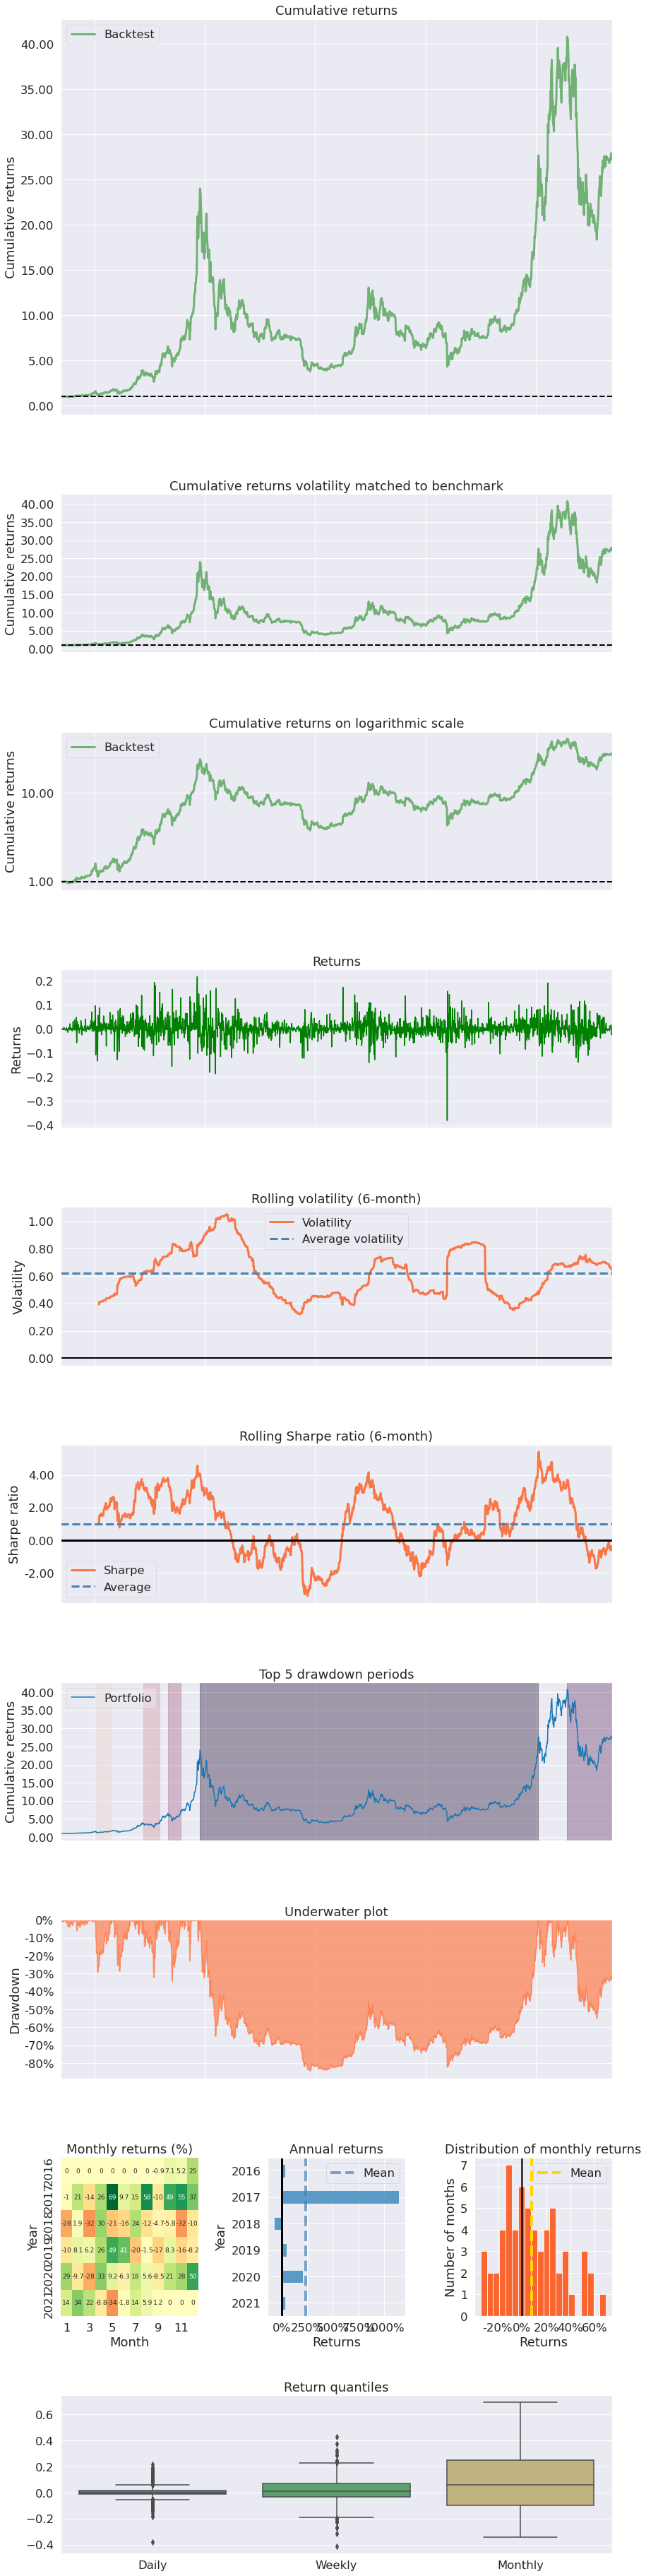

In [78]:
import pyfolio as pf
%matplotlib inline
 
return_ser = pd.read_csv(r'C:\Users\SEAN\results\account_value_g1_b1_.csv')
return_ser['date'] = pd.to_datetime(return_ser['date'])
return_ser.set_index('date', inplace=True)
pf.create_returns_tear_sheet(return_ser['daily_return'])